In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
tb.__version__

'0.0.3.13'

In [3]:
EXPERIMENT_NAME = '1122-Scene1-LSTM-SmallWindow-UseD'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene1_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene1_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [4]:
WINDOW_SIZE = 48

In [5]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z',
                      'dyaw', 'dpitch', 'droll']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [6]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [7]:
len(ds_train), len(ds_test)

(18521, 19200)

In [8]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([48, 9]), torch.Size([3]))

In [9]:
x, y = ds_train[0]

In [10]:
x.shape

torch.Size([48, 9])

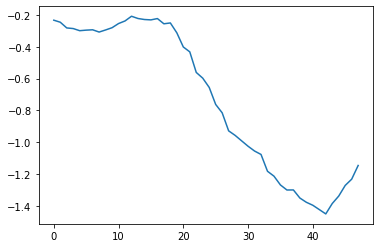

In [11]:
plt.plot(x[:, 2])

In [12]:
model = utils.BaselineLSTM(input_size=9,
                           hidden_size=64,
                           num_layers=8,
                           dropout=0.2,
                           bidirectional=True).cuda()

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [14]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [15]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [16]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [17]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.431161
 - Pitch        :  12.012720
 - Roll         :   3.100329
 - RMS          :   8.997487
 - 99% Tile     :  43.677600
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.329394
 - Pitch        :   8.757336
 - Roll         :   3.098619
 - RMS          :   7.601096
 - 99% Tile     :  40.997388
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.157693
 - Pitch        :   7.679312
 - Roll         :   3.074466
 - RMS          :   7.124781
 - 99% Tile     :  38.452014
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.930007
 - Pitch        :   7.029823
 - Roll         :   2.980671
 - RMS          :   5.581750
 - 99% Tile     :  33.967163
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.979354
 - Pitch        :   5.272795
 - Roll         :   2.958759
 - RMS          :   4.522189
 - 99% Tile     :  31.637779
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.149601
 - Pitch        :   4.401410
 - Roll         :   2.933189
 - RMS          :   3.881374
 - 99% Tile     :  28.507372
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.472141
 - Pitch        :   3.718437
 - Roll         :   2.915672
 - RMS          :   3.385443
 - 99% Tile     :  26.447877
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.080380
 - Pitch        :   3.196354
 - Roll         :   2.827036
 - RMS          :   3.038506
 - 99% Tile     :  24.320712
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.834339
 - Pitch        :   2.552310
 - Roll         :   2.849918
 - RMS          :   2.748927
 - 99% Tile     :  22.142154
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.375806
 - Pitch        :   2.379237
 - Roll         :   2.857802
 - RMS          :   2.547695
 - 99% Tile     :  20.712646
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.156792
 - Pitch        :   2.131102
 - Roll         :   2.866246
 - RMS          :   2.408922
 - 99% Tile     :  19.466370
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.113760
 - Pitch        :   1.950001
 - Roll         :   2.855835
 - RMS          :   2.339963
 - 99% Tile     :  18.654327
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.110285
 - Pitch        :   1.935011
 - Roll         :   2.881923
 - RMS          :   2.345425
 - 99% Tile     :  18.171515
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.714970
 - Pitch        :   1.692289
 - Roll         :   2.861160
 - RMS          :   2.159568
 - 99% Tile     :  17.801244
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.675114
 - Pitch        :   1.804286
 - Roll         :   2.808435
 - RMS          :   2.156290
 - 99% Tile     :  17.511954
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.570830
 - Pitch        :   1.571582
 - Roll         :   2.386831
 - RMS          :   1.882758
 - 99% Tile     :  16.705454
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.473413
 - Pitch        :   1.476254
 - Roll         :   2.020122
 - RMS          :   1.676421
 - 99% Tile     :  16.029625
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.472134
 - Pitch        :   1.598833
 - Roll         :   1.751696
 - RMS          :   1.611612
 - 99% Tile     :  15.115345
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.504016
 - Pitch        :   1.344036
 - Roll         :   1.617594
 - RMS          :   1.492772
 - 99% Tile     :  14.981358
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.403647
 - Pitch        :   1.488480
 - Roll         :   1.539530
 - RMS          :   1.478282
 - 99% Tile     :  14.238346
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.305044
 - Pitch        :   1.362057
 - Roll         :   1.401111
 - RMS          :   1.356644
 - 99% Tile     :  13.548821
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.355372
 - Pitch        :   1.308841
 - Roll         :   1.396559
 - RMS          :   1.354065
 - 99% Tile     :  13.534126
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.260124
 - Pitch        :   1.306749
 - Roll         :   1.252698
 - RMS          :   1.273415
 - 99% Tile     :  12.411109
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.022911
 - Pitch        :   1.281374
 - Roll         :   1.196785
 - RMS          :   1.545573
 - 99% Tile     :  12.625662
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.333979
 - Pitch        :   1.259124
 - Roll         :   1.045536
 - RMS          :   1.219021
 - 99% Tile     :  11.615197
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.127359
 - Pitch        :   1.113646
 - Roll         :   1.104572
 - RMS          :   1.115232
 - 99% Tile     :  11.514332
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.184648
 - Pitch        :   1.220400
 - Roll         :   1.101606
 - RMS          :   1.169944
 - 99% Tile     :  12.033583
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.363317
 - Pitch        :   1.115189
 - Roll         :   1.020396
 - RMS          :   1.175229
 - 99% Tile     :  11.532200
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.057282
 - Pitch        :   1.280935
 - Roll         :   1.015306
 - RMS          :   1.123905
 - 99% Tile     :  11.325085
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.989353
 - Pitch        :   1.073113
 - Roll         :   0.969118
 - RMS          :   1.011530
 - 99% Tile     :  10.854965
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.050525
 - Pitch        :   1.368830
 - Roll         :   0.950619
 - RMS          :   1.137391
 - 99% Tile     :  11.071082
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.176929
 - Pitch        :   0.994560
 - Roll         :   0.927982
 - RMS          :   1.038503
 - 99% Tile     :  11.163508
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.975611
 - Pitch        :   1.133293
 - Roll         :   0.913776
 - RMS          :   1.011790
 - 99% Tile     :  10.386846
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.017364
 - Pitch        :   1.032112
 - Roll         :   0.911848
 - RMS          :   0.988560
 - 99% Tile     :  10.488531
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.942408
 - Pitch        :   1.042834
 - Roll         :   0.894777
 - RMS          :   0.961988
 - 99% Tile     :  10.483776
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.091971
 - Pitch        :   1.490146
 - Roll         :   0.916750
 - RMS          :   1.190709
 - 99% Tile     :  10.270179
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.985210
 - Pitch        :   1.041348
 - Roll         :   0.888580
 - RMS          :   0.973759
 - 99% Tile     :  10.425212
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.928782
 - Pitch        :   0.993826
 - Roll         :   0.863492
 - RMS          :   0.930223
 - 99% Tile     :   9.932853
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.146071
 - Pitch        :   1.022108
 - Roll         :   0.882107
 - RMS          :   1.022464
 - 99% Tile     :   9.625192
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.916356
 - Pitch        :   0.985720
 - Roll         :   0.910844
 - RMS          :   0.938259
 - 99% Tile     :   9.627993
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.963550
 - Pitch        :   1.085578
 - Roll         :   0.824425
 - RMS          :   0.963775
 - 99% Tile     :   9.329740
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.101667
 - Pitch        :   1.001179
 - Roll         :   0.856772
 - RMS          :   0.991647
 - 99% Tile     :   9.520075
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.270608
 - Pitch        :   1.032739
 - Roll         :   0.833354
 - RMS          :   1.060735
 - 99% Tile     :   9.372091
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.932521
 - Pitch        :   1.090370
 - Roll         :   0.818140
 - RMS          :   0.953564
 - 99% Tile     :   9.265924
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.212668
 - Pitch        :   1.027160
 - Roll         :   0.860965
 - RMS          :   1.043532
 - 99% Tile     :   9.003152
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.144102
 - Pitch        :   1.597285
 - Roll         :   0.983033
 - RMS          :   1.268417
 - 99% Tile     :   9.409704
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.989461
 - Pitch        :   1.046267
 - Roll         :   0.812432
 - RMS          :   0.954595
 - 99% Tile     :   8.770588
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.082974
 - Pitch        :   0.956827
 - Roll         :   0.822513
 - RMS          :   0.960014
 - 99% Tile     :   8.836027
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.506477
 - Pitch        :   1.075417
 - Roll         :   0.795582
 - RMS          :   1.163177
 - 99% Tile     :   8.822711
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.847336
 - Pitch        :   0.971457
 - Roll         :   0.779550
 - RMS          :   0.869752
 - 99% Tile     :   8.589727
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.948623
 - Pitch        :   1.013282
 - Roll         :   0.800509
 - RMS          :   0.925102
 - 99% Tile     :   8.642306
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.092363
 - Pitch        :   1.030959
 - Roll         :   0.813410
 - RMS          :   0.986199
 - 99% Tile     :   8.545604
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.884344
 - Pitch        :   1.058249
 - Roll         :   0.794526
 - RMS          :   0.918917
 - 99% Tile     :   8.691987
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.932439
 - Pitch        :   0.958482
 - Roll         :   0.794386
 - RMS          :   0.897994
 - 99% Tile     :   8.324903
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.140849
 - Pitch        :   1.011735
 - Roll         :   0.827235
 - RMS          :   1.001576
 - 99% Tile     :   8.602416
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.029727
 - Pitch        :   1.078898
 - Roll         :   0.739575
 - RMS          :   0.961133
 - 99% Tile     :   8.257279
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.001149
 - Pitch        :   0.994410
 - Roll         :   0.785639
 - RMS          :   0.932448
 - 99% Tile     :   8.341756
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.048600
 - Pitch        :   1.070509
 - Roll         :   0.735837
 - RMS          :   0.963848
 - 99% Tile     :   8.593355
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.960187
 - Pitch        :   0.980557
 - Roll         :   0.725732
 - RMS          :   0.896314
 - 99% Tile     :   8.755066
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.904755
 - Pitch        :   0.911569
 - Roll         :   0.697501
 - RMS          :   0.843810
 - 99% Tile     :   8.289958
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.999741
 - Pitch        :   1.040892
 - Roll         :   0.750217
 - RMS          :   0.939107
 - 99% Tile     :   8.527605
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0061.npy


[0063/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.993959
 - Pitch        :   0.997333
 - Roll         :   0.718699
 - RMS          :   0.912717
 - 99% Tile     :   8.960992
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0062.npy


[0064/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.912804
 - Pitch        :   0.903970
 - Roll         :   0.722469
 - RMS          :   0.850947
 - 99% Tile     :   8.422144
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0063.npy


[0065/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.924407
 - Pitch        :   0.992688
 - Roll         :   0.693290
 - RMS          :   0.879509
 - 99% Tile     :   8.282066
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0064.npy


[0066/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.879390
 - Pitch        :   0.931212
 - Roll         :   0.705899
 - RMS          :   0.844349
 - 99% Tile     :   8.517859
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0065.npy


[0067/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.851127
 - Pitch        :   0.892062
 - Roll         :   0.682604
 - RMS          :   0.813662
 - 99% Tile     :   8.351444
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0066.npy


[0068/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.841557
 - Pitch        :   0.899242
 - Roll         :   0.685575
 - RMS          :   0.813811
 - 99% Tile     :   8.415157
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0067.npy


[0069/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.894153
 - Pitch        :   0.939741
 - Roll         :   0.683889
 - RMS          :   0.846626
 - 99% Tile     :   8.262391
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0068.npy


[0070/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.933265
 - Pitch        :   1.033187
 - Roll         :   0.701473
 - RMS          :   0.900097
 - 99% Tile     :   8.467349
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0069.npy


[0071/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.852491
 - Pitch        :   0.885850
 - Roll         :   0.701326
 - RMS          :   0.817176
 - 99% Tile     :   8.319670
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0070.npy


[0072/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.904165
 - Pitch        :   0.951471
 - Roll         :   0.678937
 - RMS          :   0.853184
 - 99% Tile     :   8.739332
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0071.npy


[0073/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.902165
 - Pitch        :   1.054146
 - Roll         :   0.695345
 - RMS          :   0.896034
 - 99% Tile     :   8.920502
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0072.npy


[0074/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.912818
 - Pitch        :   0.939244
 - Roll         :   0.699352
 - RMS          :   0.857226
 - 99% Tile     :   8.557097
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0073.npy


[0075/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.902088
 - Pitch        :   0.983187
 - Roll         :   0.720010
 - RMS          :   0.875373
 - 99% Tile     :   8.391034
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0074.npy


[0076/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.921952
 - Pitch        :   0.915666
 - Roll         :   0.678621
 - RMS          :   0.846358
 - 99% Tile     :   8.607209
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0075.npy


[0077/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.880774
 - Pitch        :   0.973772
 - Roll         :   0.702689
 - RMS          :   0.859800
 - 99% Tile     :   8.481998
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0076.npy


[0078/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.890818
 - Pitch        :   0.939163
 - Roll         :   0.677716
 - RMS          :   0.843580
 - 99% Tile     :   8.646544
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0077.npy


[0079/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.873310
 - Pitch        :   0.997599
 - Roll         :   0.686646
 - RMS          :   0.862043
 - 99% Tile     :   8.777251
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0078.npy


[0080/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.865723
 - Pitch        :   0.945642
 - Roll         :   0.681910
 - RMS          :   0.838394
 - 99% Tile     :   8.840391
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0079.npy


[0080/0100] Validation: 100%|██████████████████████| 75/75 [00:03<00:00, 20.29it/s, val_loss 4.4702]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.876480
 - Pitch        :   0.935440
 - Roll         :   0.663503
 - RMS          :   0.833367
 - 99% Tile     :   8.828422
Save output signals into checkpoint/1122-Scene1-LSTM-SmallWindow-UseD/sample/0080.npy
